In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from ast import literal_eval


In [51]:
data.head()

,Unnamed: 0,time_steps,why,average_reward,kickable_percentages
0,0,200.0,OutOfTime,[-16.780103210313666],0.0
1,1,199.0,OutOfTime,[-15.9218138116907],0.0
2,2,199.0,OutOfTime,[-15.404931935526736],0.0
3,3,199.0,OutOfTime,[-17.4098090611903],0.0
4,4,199.0,OutOfTime,[-20.582214000902297],0.0


number of episodes finished 6635


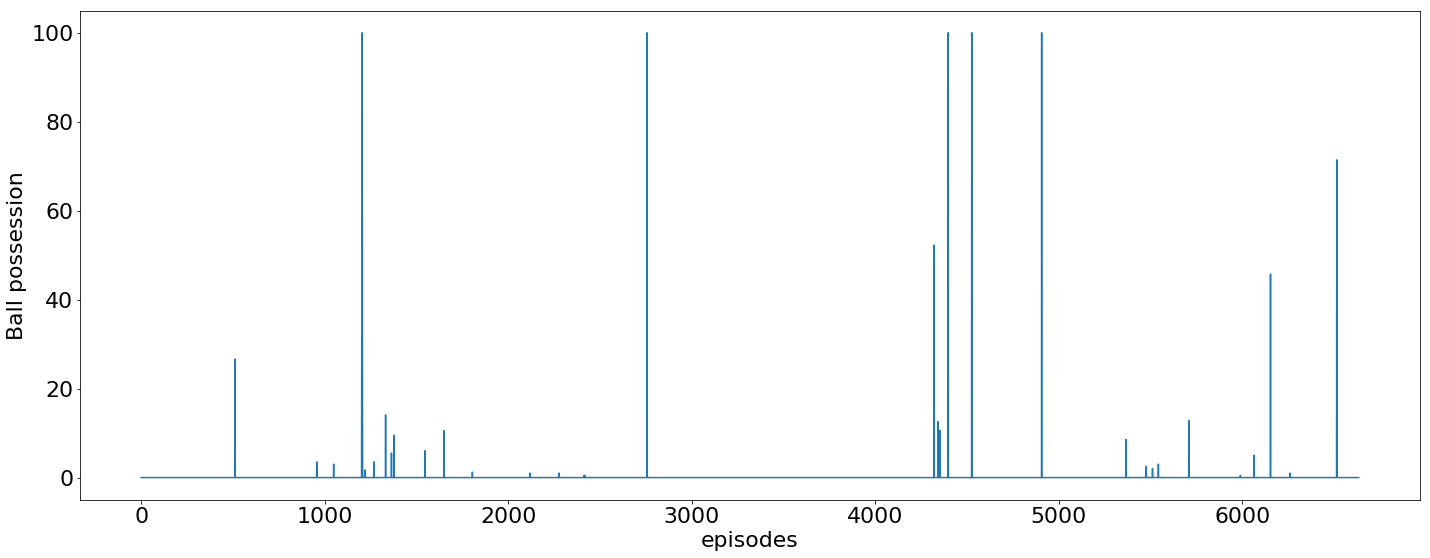

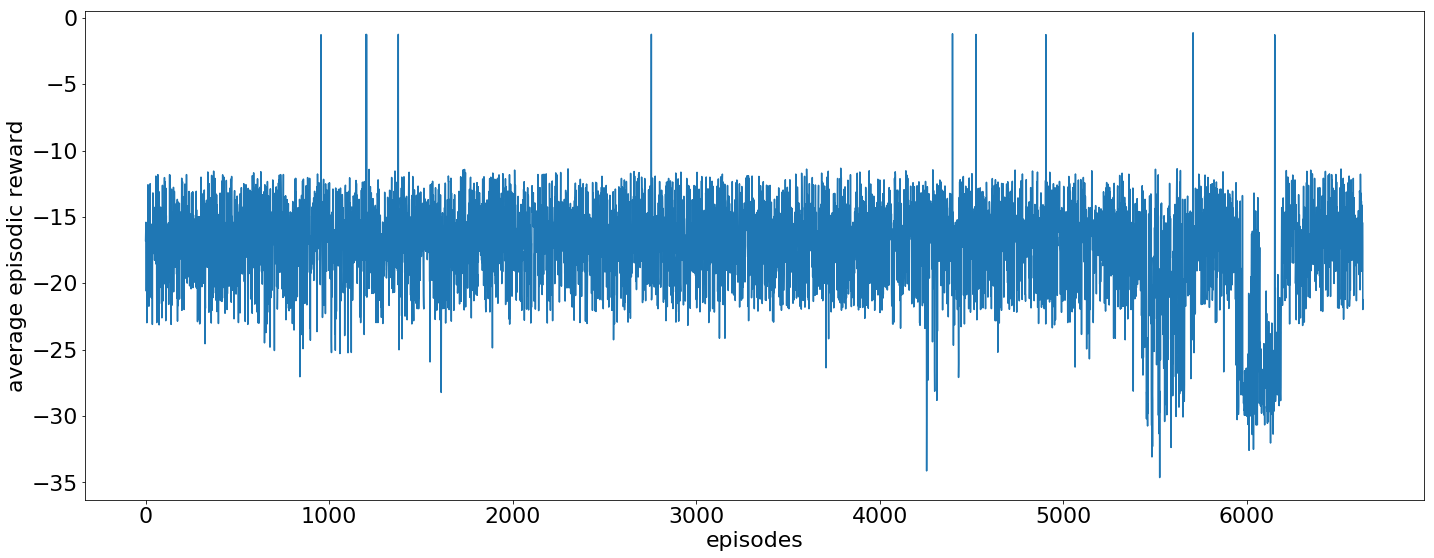

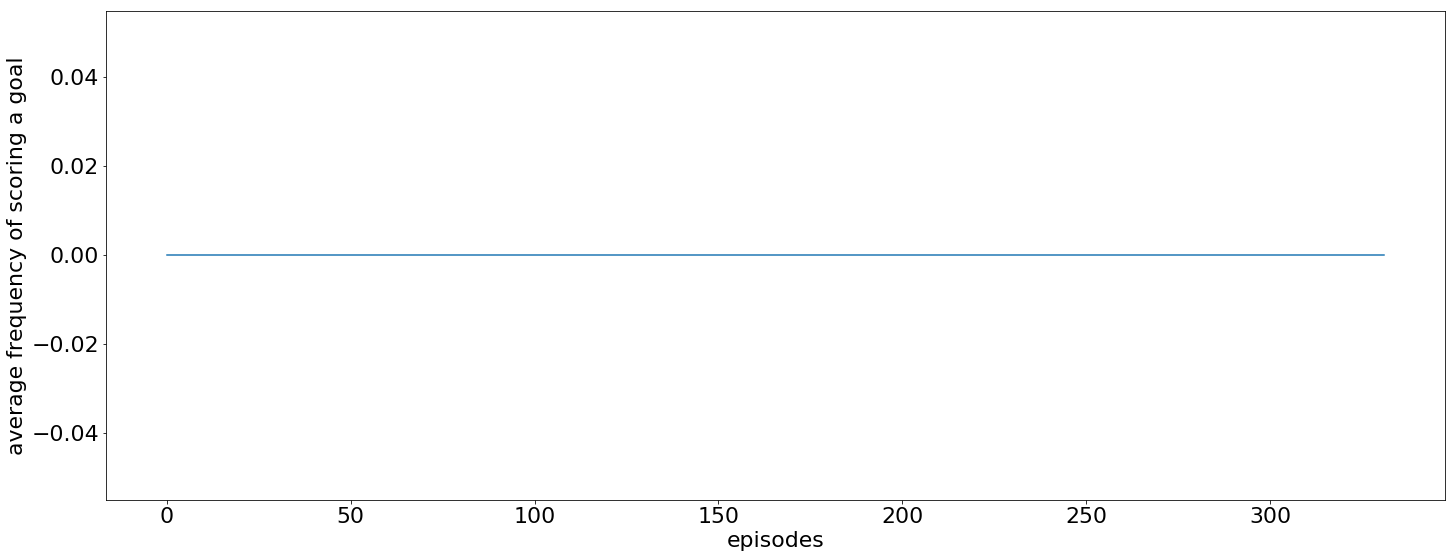

In [61]:
goal_frequency_window = 20

data = pd.read_csv('history.csv')

print('number of episodes finished %d'%len(data))

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(data.kickable_percentages)
plt.xlabel('episodes')
plt.ylabel('Ball possession')
plt.show()


reward = []
for i in range(len(data)):
    reward.append(literal_eval(data.average_reward[i]))
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(reward)
plt.xlabel('episodes')
plt.ylabel('average episodic reward')
plt.show()


goal_freq = []
for i in range(0, len(data), goal_frequency_window):
    temp = data.loc[i:i+goal_frequency_window].why.value_counts()
    
    try: 
        goal_freq.append(temp.Goal)
    except AttributeError:
        goal_freq.append(0)
        
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(24,9))
plt.plot(goal_freq)
plt.xlabel('episodes')
plt.ylabel('average frequency of scoring a goal')
plt.show()
        